### Import Lib

In [1]:
import sys   #导入sys模块
sys.path.append("..")

import pandas as pd
import numpy as np
from obspy import read
from tqdm import tqdm
from geopy.distance import geodesic

import matplotlib.pyplot as plt


### import Function

In [2]:
from detect_peaks import *
from model_ridgecrest_continue import *
from continue_24_dataloader_2loss import *

In [3]:
def load_model(model_name,model):
    param = torch.load(model_name,map_location='cpu')['net']
    model.load_state_dict(param)
    return model

### read model

In [4]:
device = torch.device('cpu')
model = Main_GCNN('Trans').to(device)
load_model_name = './model_1100.pt'
model = load_model(load_model_name,model)

In [5]:
# for pred, network need the station info
station_pandas = pd.read_csv("./gmap-stations.txt", sep='|')
station_pandas = station_pandas.drop([0])
station_name = station_pandas.iloc[:,1].tolist()
# Here, we test our model on continous data from ridgecrest region in 2019.7.4:17.30.00
# we read the data from 16 stations
data = np.zeros([len(station_name),3,360001])
HN_list = ['WRV2','WNM','WVP2']
for index,name in tqdm(enumerate(station_name)):
    if (name in HN_list) == True:
        dataname1 = '../data/1h/20190704173000.CI.' + str(name) + '.HNN.sac'
        dataname2 = '../data/1h/20190704173000.CI.' + str(name) + '.HNE.sac'
        dataname3 = '../data/1h/20190704173000.CI.' + str(name) + '.HNZ.sac'
    if (name in HN_list) == False:   
        dataname1 = '../data/1h/20190704173000.CI.' + str(name) + '.HHN.sac'
        dataname2 = '../data/1h/20190704173000.CI.' + str(name) + '.HHE.sac'
        dataname3 = '../data/1h/20190704173000.CI.' + str(name) + '.HHZ.sac'
    tempdata1 = read(dataname1)
    tr1 = tempdata1[0]
    tempdata2 = read(dataname2)    
    tr2 = tempdata2[0]
    tempdata3 = read(dataname3)    
    tr3 = tempdata3[0]
    data[index,0,:] = tr1
    data[index,1,:] = tr2
    data[index,2,:] = tr3
    


16it [00:06,  2.43it/s]


### Select three data for test 

In [6]:
# Here, we first select three data for test,because the sample rate is 100Hz,
# data start time is 17:30:00,so the select date start time is [17:40:00,17:40:10,17:40:20],the length is 3072=30.72s
# therefore the first and the third data is corresponding to the following two events
# 2019/07/04,17:40:02.250  35.7253   -117.5708  M:3.80
# 2019/07/04,17:40:18.520  35.7070   -117.5102  M:4.13
left_index = np.arange(60000,63000,1000)
right_index = left_index + 3072
print(left_index,right_index)
output_loc = np.zeros([16,len(left_index)])
output_depth = np.zeros([len(left_index),1])


[60000 61000 62000] [63072 64072 65072]


In [7]:
bs = 64
edgefilepath = './edge_index.npy'

inputdata_dataset = MyGNNDataset_continue(edgefilepath,data,left_index,right_index)
train_loader = gdata.DataLoader(inputdata_dataset, shuffle = False, batch_size=1,num_workers = 4)

### Get the pred and plot  

  0%|                                                     | 0/3 [00:00<?, ?it/s]/Users/xusi/anaconda3/envs/pyg2.0/lib/python3.9/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)
/Users/xusi/anaconda3/envs/pyg2.0/lib/python3.9/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)
/Users/xusi/anaconda3/envs/pyg2.0/lib/python3.9/site-package

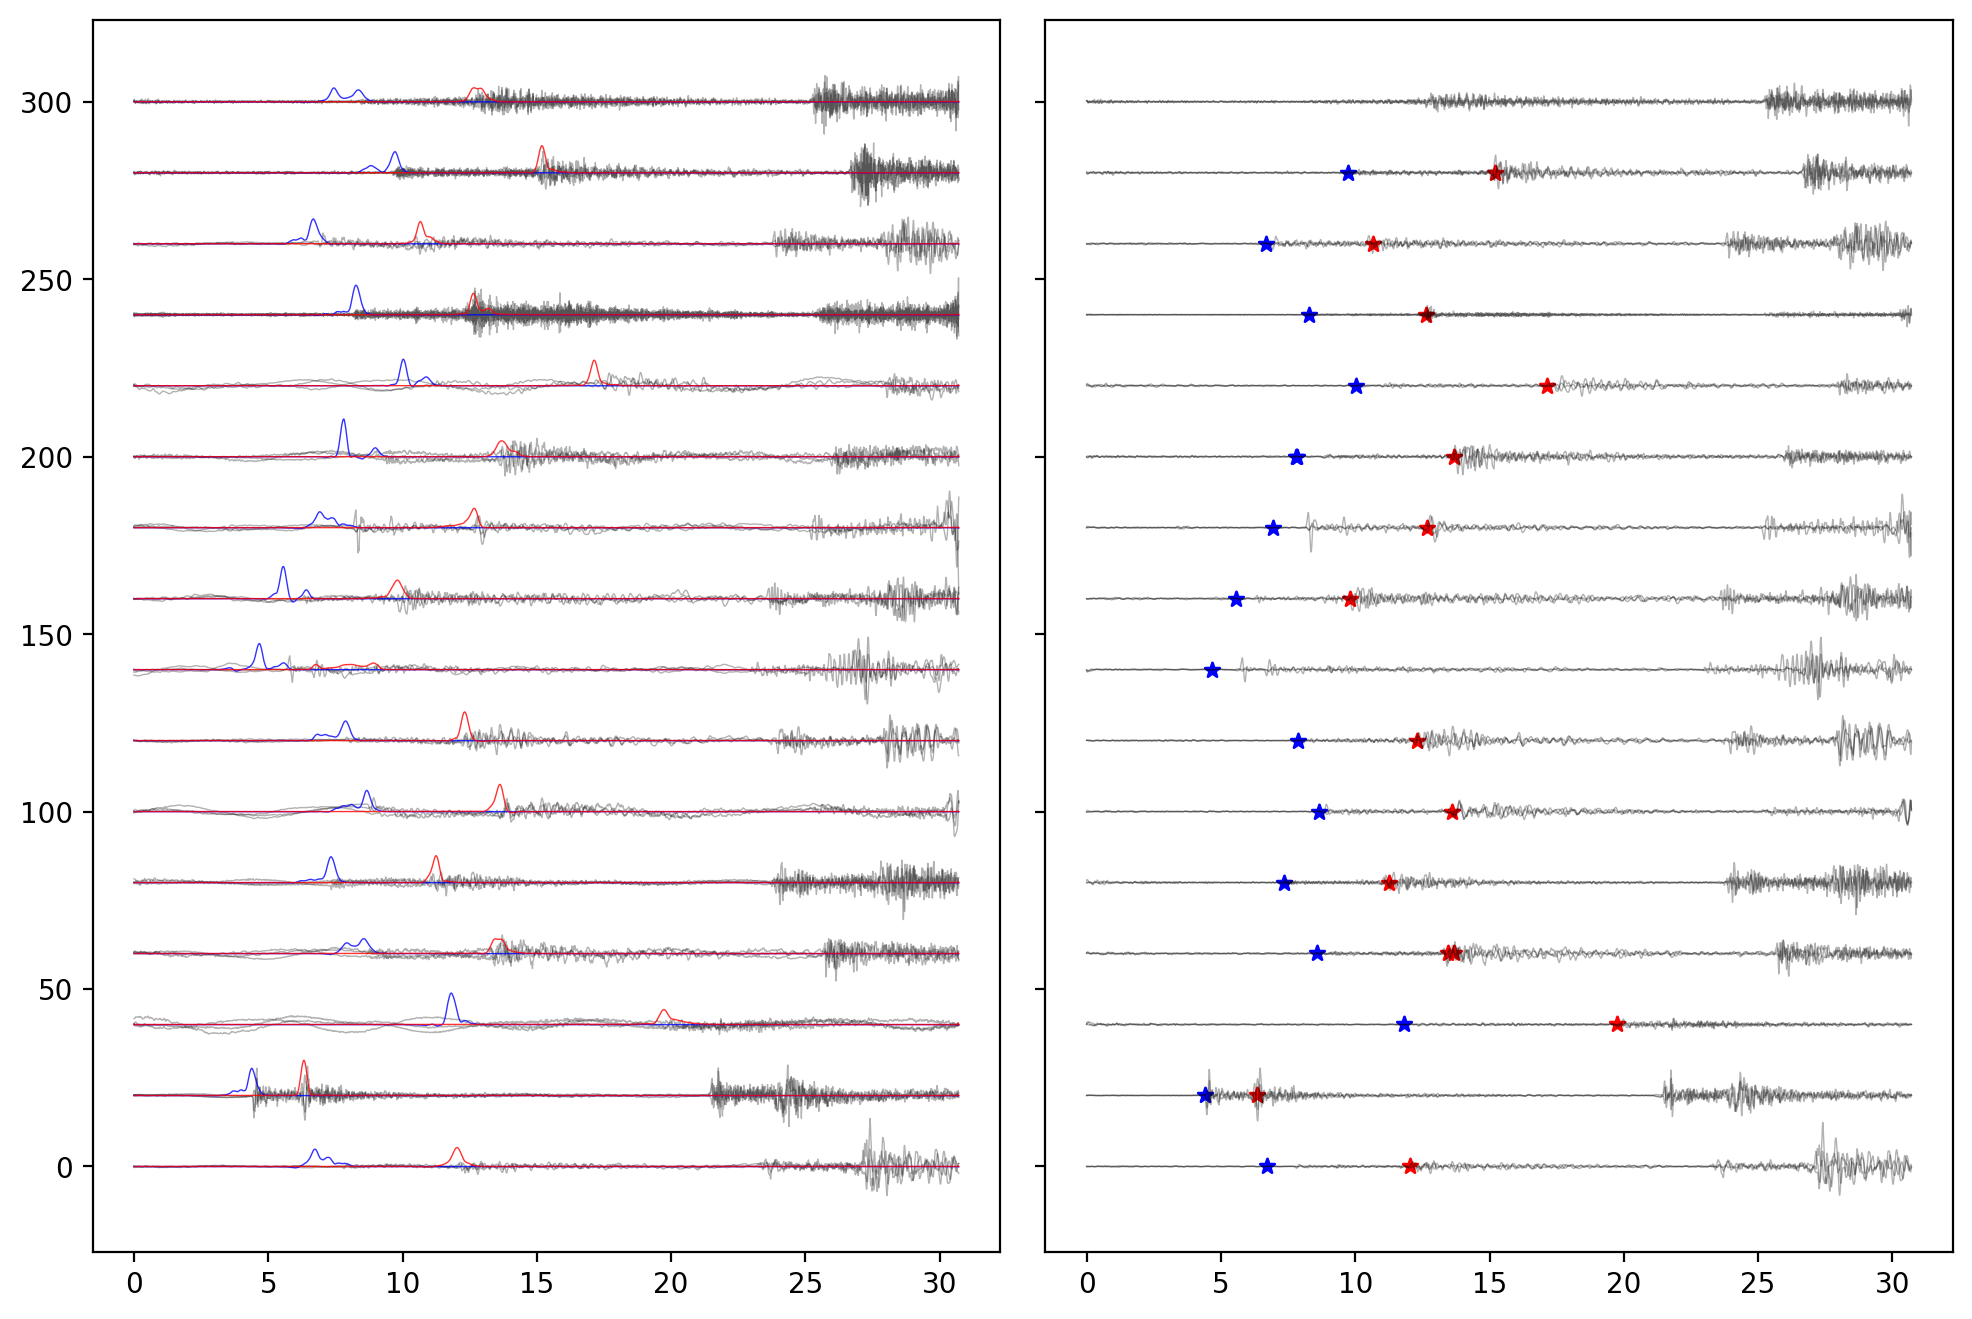

 33%|███████████████                              | 1/3 [00:15<00:30, 15.41s/it]

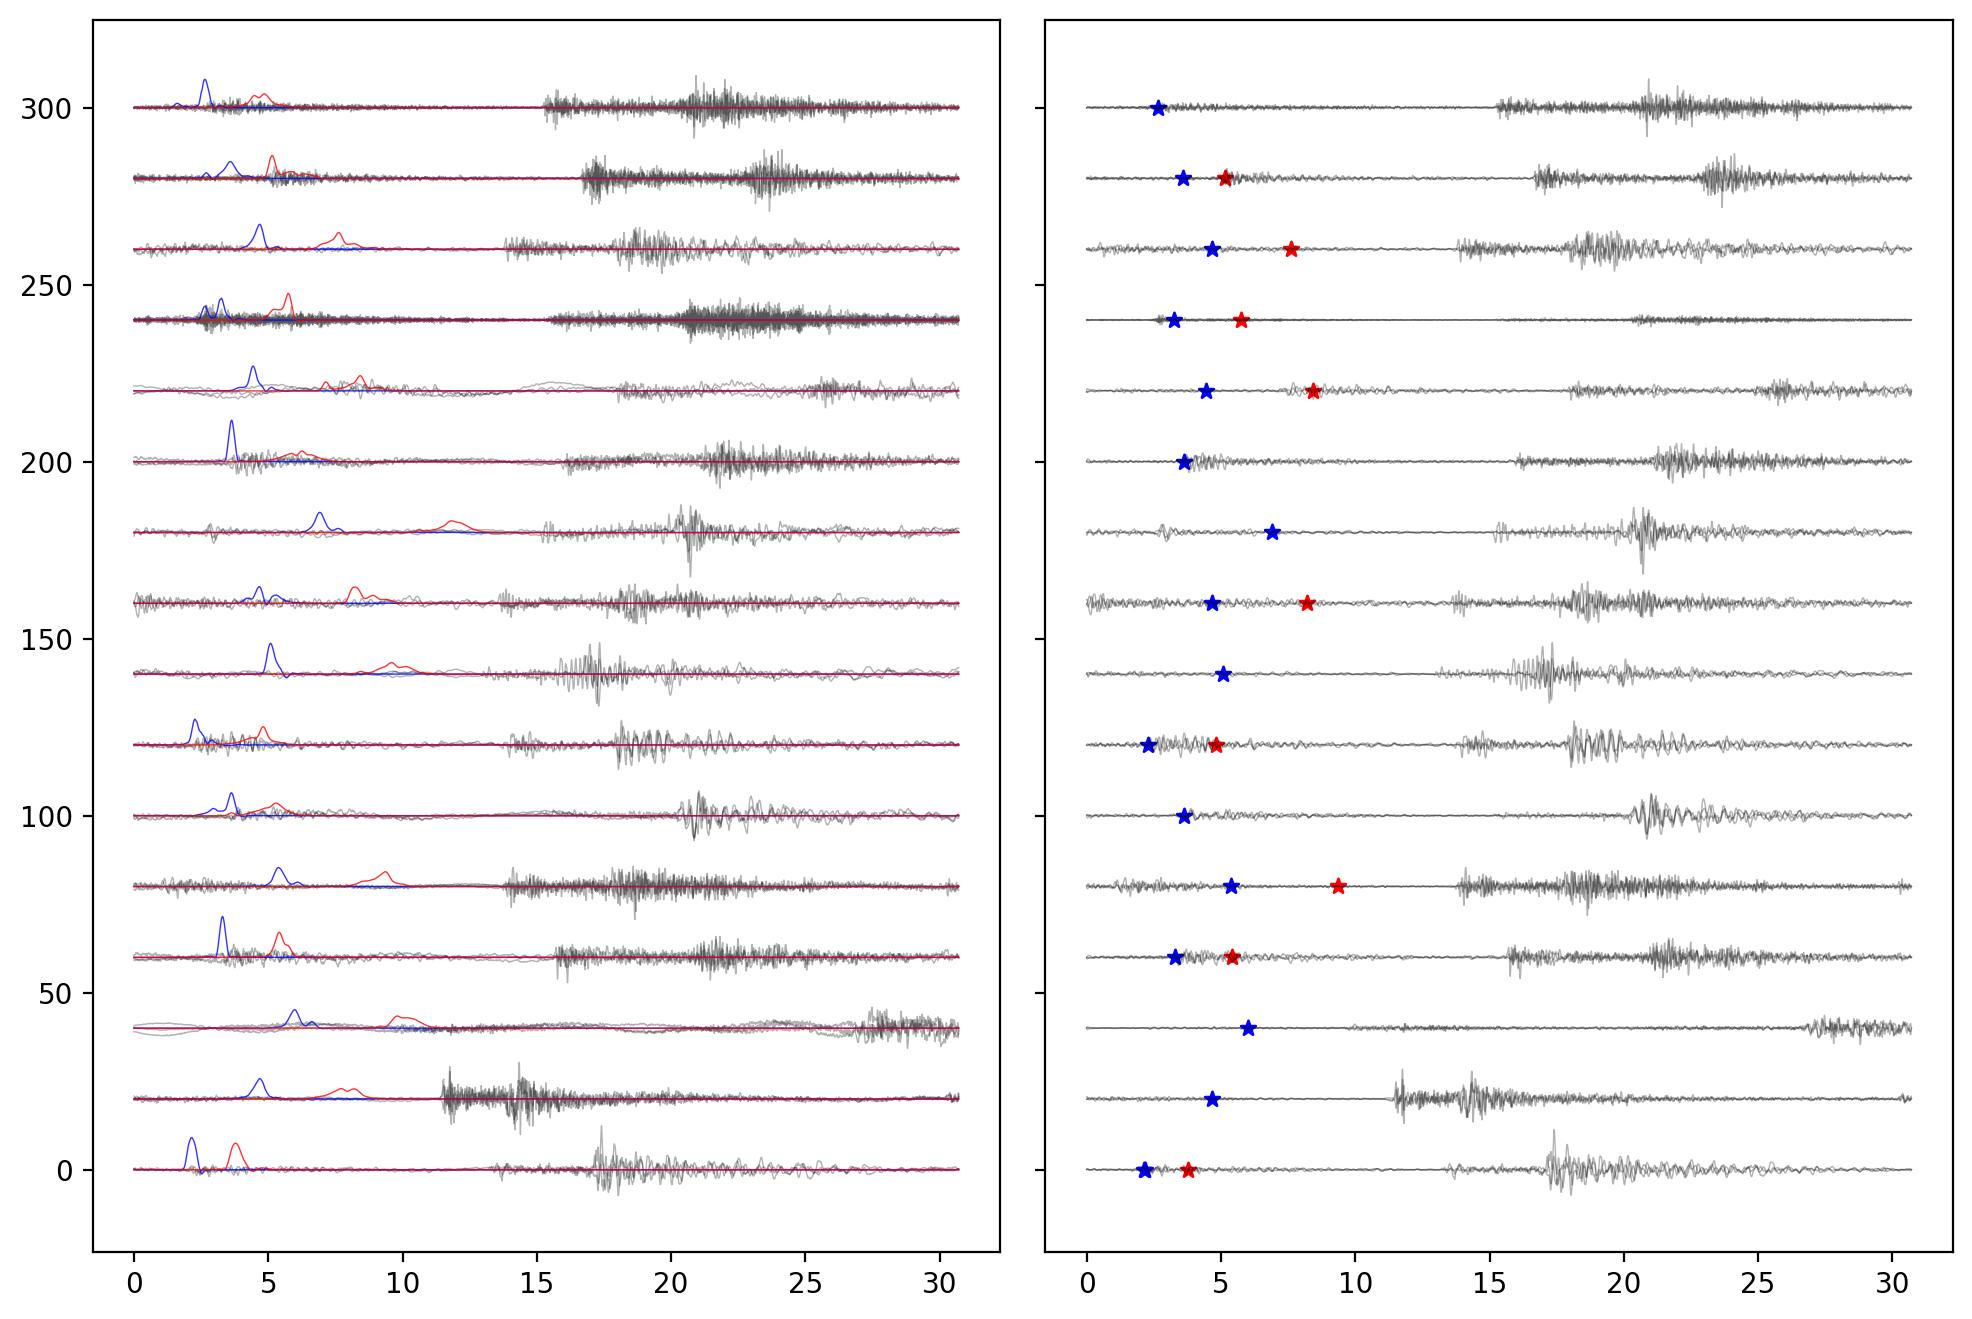

 67%|██████████████████████████████               | 2/3 [00:16<00:07,  7.10s/it]

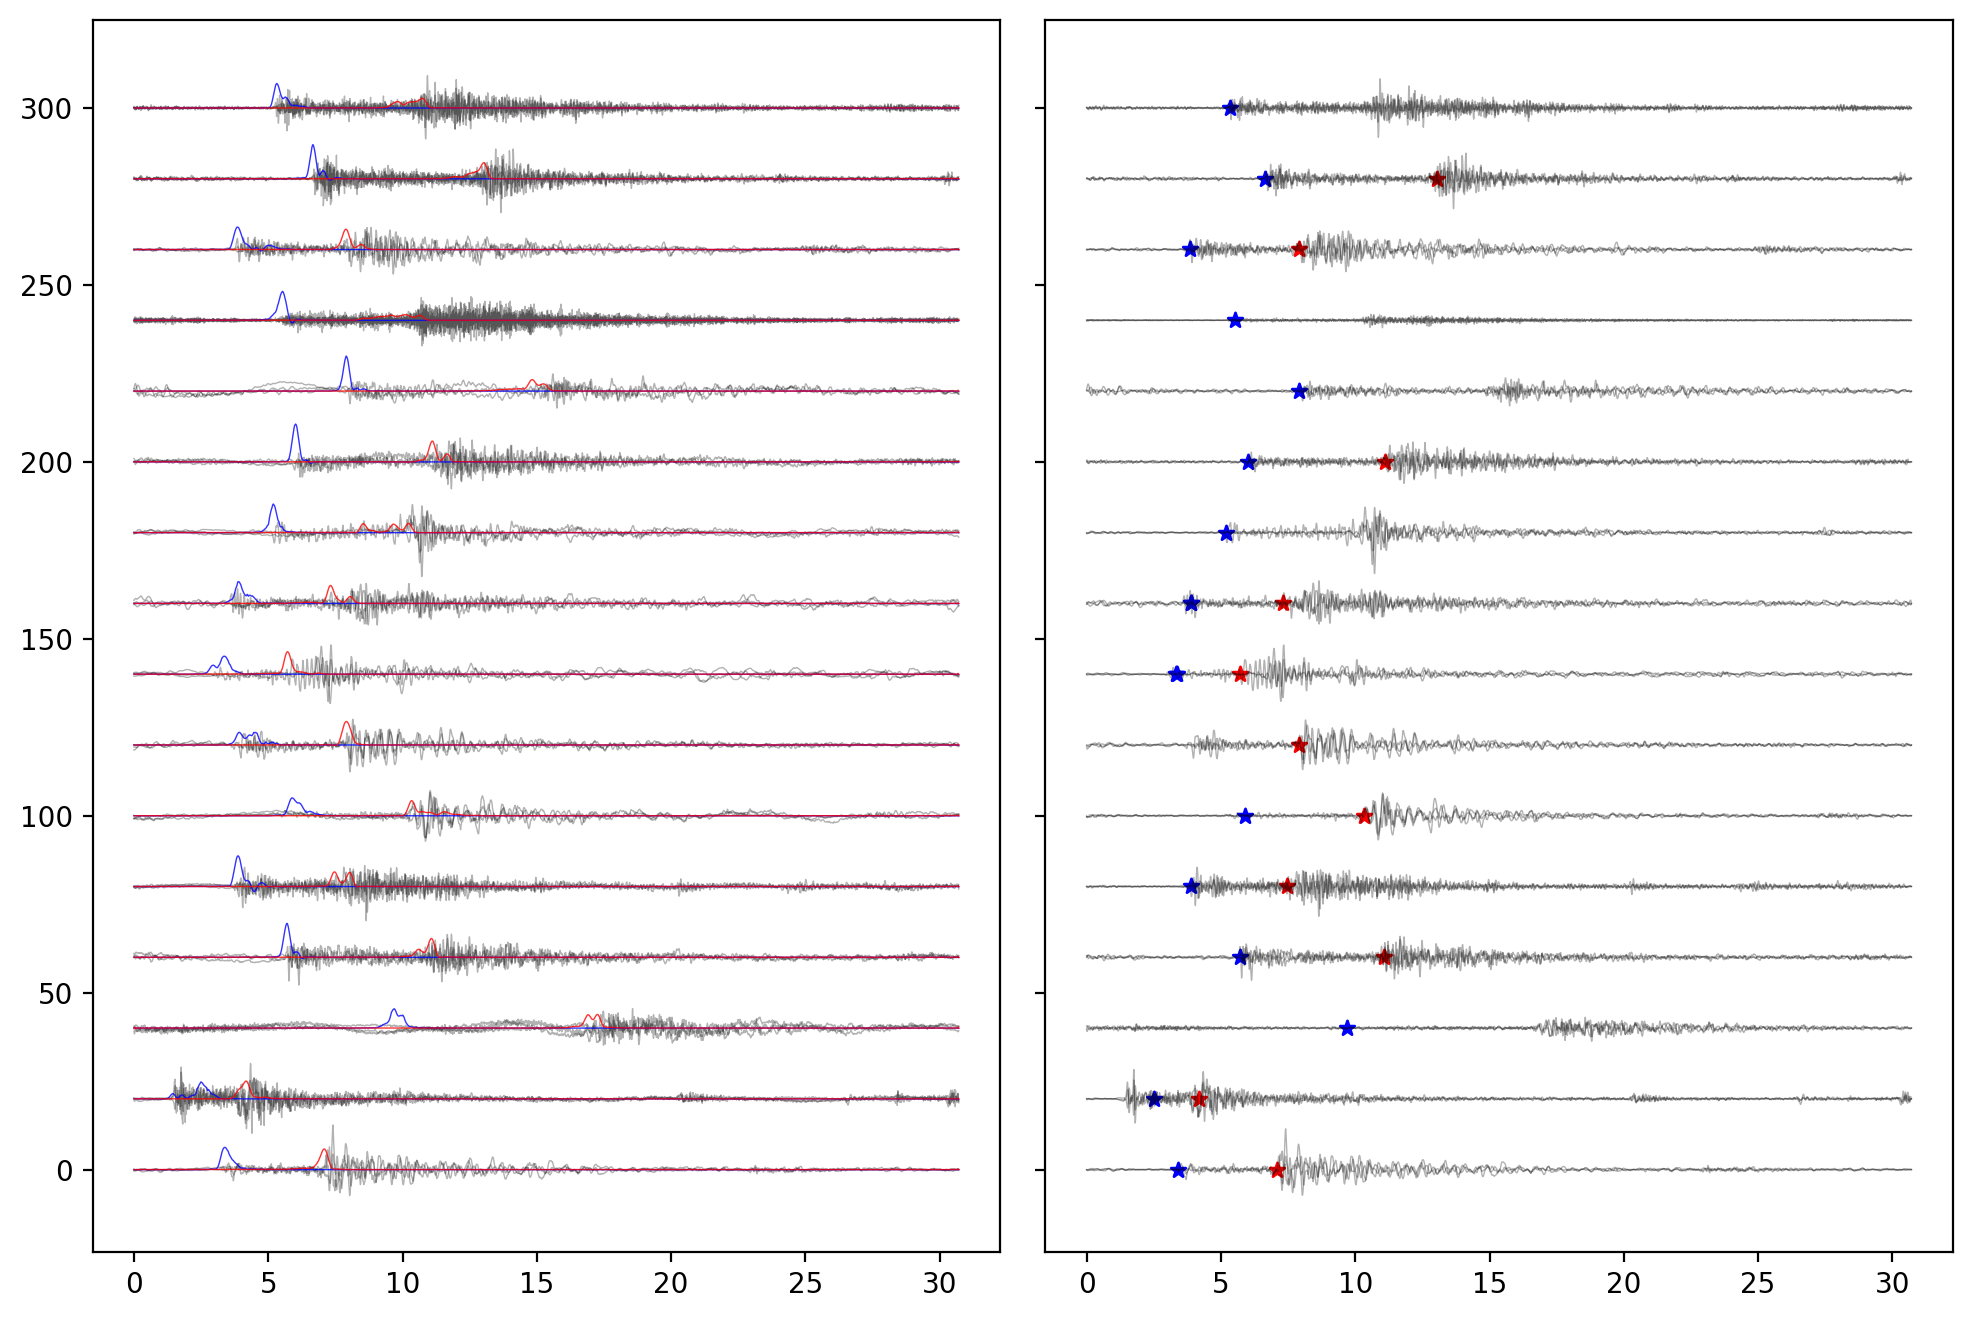

100%|█████████████████████████████████████████████| 3/3 [00:32<00:00, 10.96s/it]


In [10]:
# Before run this cell, run the last two cells in this jupyter 
m = 0
for mydata in tqdm(train_loader):
    mydata = mydata.to(device)
    out_p,out_s,pred_loc,pred_depth,dtp,dts = model(mydata.x,mydata.station_loc, mydata.batch,mydata.edge_index)
    output_loc[:,m*bs:(m+1)*bs] = pred_loc.cpu().detach().squeeze().numpy().reshape((16,-1),order='F')
    output_depth[m*bs:(m+1)*bs] = pred_depth.cpu().detach().numpy()
    
    plot_signal_continue(mydata.x.detach().numpy(),out_p.detach().numpy(),out_s.detach().numpy())    
    m += 1

# cal_log 

In [11]:
def get_repred_mask(ppred,spred,threshold = 0.4):
    mask = np.zeros(16)
    for i in range(len(ppred)):
        temp_pick_p = detect_peaks(ppred[i,0],mph = threshold, show=False)
        temp_pick_s = detect_peaks(spred[i,0],mph = threshold, show=False)
        # print(len(temp_pick_p[0]),len(temp_pick_s[0]))
        if (len(temp_pick_p[0]>0) & len(temp_pick_s[0]>0)):
            mask[i] = 1
        
    return mask

    
def cal_edge(pos_init):
    # pos = np.zeros([pos_init*(pos_init-1),2])
    # k = 0
    # for i in range (pos_init**2):
    #     if int(i/pos_init) != int(i%pos_init):
    #         pos[k,0] = int(i/pos_init)
    #         pos[k,1] = int(i%pos_init)
            # k += 1
    pos = np.zeros([pos_init**2,2])
    k = 0
    for i in range (pos_init**2):
        pos[i,0] = int(i/pos_init)
        pos[i,1] = int(i%pos_init)
    return pos

from datetime import datetime, timedelta

def distance_to_time(sample, time_start):
    # convert time_start to datetime object
    start_time = datetime.strptime(time_start, '%Y-%m-%d %H:%M:%S.%f')
    # calculate time delta based on sample and time interval
    delta = timedelta(seconds=(sample/100))
                      
    # add time delta to start time
    end_time = start_time + delta

    # convert end time to string
    end_time_str = end_time.strftime('%Y-%m-%d %H:%M:%S.%f')

    return end_time_str


In [12]:
# use 4.5s step to generate the catalog in 120s 
left_index = np.arange(55000,67000,450)
right_index = left_index + 3072
print(len(left_index))
print(left_index)
print(right_index)
output_loc = np.zeros([16,len(left_index)])
output_depth = np.zeros([len(left_index),1])

bs = 64
edgefilepath = './edge_index.npy'

inputdata_dataset = MyGNNDataset_continue(edgefilepath,data,left_index,right_index)
train_loader = gdata.DataLoader(inputdata_dataset, shuffle = False, batch_size=1,num_workers = 4)

27
[55000 55450 55900 56350 56800 57250 57700 58150 58600 59050 59500 59950
 60400 60850 61300 61750 62200 62650 63100 63550 64000 64450 64900 65350
 65800 66250 66700]
[58072 58522 58972 59422 59872 60322 60772 61222 61672 62122 62572 63022
 63472 63922 64372 64822 65272 65722 66172 66622 67072 67522 67972 68422
 68872 69322 69772]


In [13]:
import warnings
warnings.filterwarnings("ignore")
# generate the catalog in 120s
m = 0
earthquake_time_list = []
# test 
for mydata in tqdm(train_loader):
    mydata = mydata.to(device)
    # print(mydata.x.shape)
    out_p,out_s,pred_loc,pred_depth,dtp,dts = model(mydata.x,mydata.station_loc, mydata.batch,mydata.edge_index)
    
    repred_mask = get_repred_mask(out_p.detach().numpy(),out_s.detach().numpy(),threshold = 0.5)
    # calculate mask for each event
    repred_mask = repred_mask == 1
    # print(repred_mask)
    
    list_pick_p = []
    list_pick_s = []
    temp_pick_sp = np.zeros([len(out_p),2])
    for i in range(len(out_p)):
        temp_pick_p = detect_peaks(out_p.detach().numpy()[i,0],mph=0.4, show=False)
        temp_pick_s = detect_peaks(out_s.detach().numpy()[i,0],mph=0.4, show=False)
        list_pick_s.append(temp_pick_s)
        list_pick_p.append(temp_pick_p)
        if ((len(temp_pick_p[0])>0) & (len(temp_pick_s[0])>0)):
            temp_pick_sp[i,0] = temp_pick_p[0][0] 
            temp_pick_sp[i,1] = temp_pick_s[0][0]

    pick_ps_difference = temp_pick_sp[repred_mask][:,1] - temp_pick_sp[repred_mask][:,0]
    velocity_ps_difference = (pred_loc[repred_mask]*100/3.2*100  -  pred_loc[repred_mask]*100/5.5*100).cpu().detach().numpy().squeeze()

    thershold_station = ((np.abs(velocity_ps_difference - pick_ps_difference))<100).sum()
    if thershold_station>4:
        earthquake_stime = (pred_loc[repred_mask].squeeze().detach().numpy()*100/3.2*100 - temp_pick_sp[repred_mask][:,1]).mean()
        earthquake_ptime = (pred_loc[repred_mask].squeeze().detach().numpy()*100/5.5*100 - temp_pick_sp[repred_mask][:,0]).mean()
        earthquake_time = (earthquake_stime + earthquake_ptime)/2
        # print(earthquake_ptime,earthquake_stime)
        earthquake_time = distance_to_time(left_index[m] + earthquake_time, time_start = '2019-07-04 17:30:00.000')
        earthquake_time_list.append(earthquake_time)
    m += 1


  0%|                                                    | 0/27 [00:00<?, ?it/s]/Users/xusi/anaconda3/envs/pyg2.0/lib/python3.9/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)
/Users/xusi/anaconda3/envs/pyg2.0/lib/python3.9/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)
/Users/xusi/anaconda3/envs/pyg2.0/lib/python3.9/site-package

In [14]:
earthquake_time_list

['2019-07-04 17:39:28.120675',
 '2019-07-04 17:39:37.161333',
 '2019-07-04 17:39:50.628413',
 '2019-07-04 17:39:59.596834',
 '2019-07-04 17:40:04.290859',
 '2019-07-04 17:40:08.638946',
 '2019-07-04 17:40:17.728925',
 '2019-07-04 17:40:22.284843',
 '2019-07-04 17:40:26.830019',
 '2019-07-04 17:40:31.024670',
 '2019-07-04 17:40:35.841617',
 '2019-07-04 17:40:44.870496',
 '2019-07-04 17:40:49.150782',
 '2019-07-04 17:40:57.997727',
 '2019-07-04 17:41:02.742040']

In [8]:
# plot the data 
def plot_signal_continue(raw,ppred,spred,ntstart = 0,ntend = 3072, etstart = 0,etend = 3072, ztstart = 0,ztend = 3072, savefig = False, figname = 'test.png'):
    
    fontdict = {'weight' : 'normal', 'size' : 8}
    fontdict1 = {'weight' : 'normal', 'size' : 14}
    fontdict2 = {'weight' : 'normal', 'size' : 10}
    
    i = 0
    temp = raw.copy()
    # temp[:,2,:]  = raw[:,0,:].copy()
    # temp[:,0,:]  = raw[:,2,:].copy()
    scale = 10
    fig, ax = plt.subplots(1,2,sharey=True,figsize=(12,8),dpi = 200)
    # fig, ax = plt.subplots(2,3,sharey=True,figsize=(12,12),dpi = 150)
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.05, hspace=None)
    x = []
    x.append(np.arange(ntstart/100,ntend/100,0.01))
    x.append(np.arange(etstart/100,etend/100,0.01))
    x.append(np.arange(ztstart/100,ztend/100,0.01))
    xtick = list(np.arange(0,30+0.1 ,5))
    xtick_label = ['%.0f'%i for i in xtick]
    i = 0
    for j in range(len(raw)):
        line1, = ax[0].plot(x[i],temp[j,0,:]+j*20,'black',linewidth = 0.5,alpha=0.3)
        line1, = ax[0].plot(x[i],temp[j,1,:]+j*20,'black',linewidth = 0.5,alpha=0.3)
        line1, = ax[0].plot(x[i],temp[j,2,:]+j*20,'black',linewidth = 0.5,alpha=0.3)
        line2, = ax[0].plot(x[i],ppred[j,0,:]*10+j*20,'blue',linewidth = 0.5,alpha=0.8)
        line3, = ax[0].plot(x[i],spred[j,0,:]*10+j*20,'red',linewidth = 0.5,alpha=0.8)
        
        
        
        line1, = ax[1].plot(x[i],bandpass(temp[j,0,:],1,15,100,corners=2, zerophase=True)+j*20,'black',linewidth = 0.5,alpha=0.3)
        line1, = ax[1].plot(x[i],bandpass(temp[j,1,:],1,15,100,corners=2, zerophase=True)+j*20,'black',linewidth = 0.5,alpha=0.3)
        line1, = ax[1].plot(x[i],bandpass(temp[j,2,:],1,15,100,corners=2, zerophase=True)+j*20,'black',linewidth = 0.5,alpha=0.3)
        temp_pick_p = detect_peaks(ppred[j,0],mph=0.4, show=False)
        temp_pick_s = detect_peaks(spred[j,0],mph=0.4, show=False)
        
        for m in range(len(temp_pick_p[0])):
            line4 = ax[1].scatter(temp_pick_p[0][m]/100,j*20,s=30,c='blue',marker='*')
        for m in range(len(temp_pick_s[0])):
            line4 = ax[1].scatter(temp_pick_s[0][m]/100,j*20,s=30,c='red',marker='*')
            
    if savefig == True:
        plt.savefig(figname,dpi = 300,bbox_inches='tight')
    # plt.close()
    plt.show()

In [9]:
from scipy.fftpack import hilbert
from scipy.signal import (cheb2ord, cheby2, convolve, get_window, iirfilter,
                          remez)
from scipy.signal import sosfilt
from scipy.signal import zpk2sos

def bandpass(data, freqmin, freqmax, df, corners=4, zerophase=False):
    """
    Butterworth-Bandpass Filter.

    Filter data from ``freqmin`` to ``freqmax`` using ``corners``
    corners.
    The filter uses :func:`scipy.signal.iirfilter` (for design)
    and :func:`scipy.signal.sosfilt` (for applying the filter).

    :type data: numpy.ndarray
    :param data: Data to filter.
    :param freqmin: Pass band low corner frequency.
    :param freqmax: Pass band high corner frequency.
    :param df: Sampling rate in Hz.
    :param corners: Filter corners / order.
    :param zerophase: If True, apply filter once forwards and once backwards.
        This results in twice the filter order but zero phase shift in
        the resulting filtered trace.
    :return: Filtered data.
    """
    fe = 0.5 * df
    low = freqmin / fe
    high = freqmax / fe
    # raise for some bad scenarios
    if high - 1.0 > -1e-6:
        msg = ("Selected high corner frequency ({}) of bandpass is at or "
               "above Nyquist ({}). Applying a high-pass instead.").format(
            freqmax, fe)
        warnings.warn(msg)
        return highpass(data, freq=freqmin, df=df, corners=corners,
                        zerophase=zerophase)
    if low > 1:
        msg = "Selected low corner frequency is above Nyquist."
        raise ValueError(msg)
    z, p, k = iirfilter(corners, [low, high], btype='band',
                        ftype='butter', output='zpk')
    sos = zpk2sos(z, p, k)
    if zerophase:
        firstpass = sosfilt(sos, data)
        return sosfilt(sos, firstpass[::-1])[::-1]
    else:
        return sosfilt(sos, data)